In [1]:
using Plots, DataFrames, StatsPlots 
using Random, LinearAlgebra, Statistics, CSV
pyplot()

Plots.PyPlotBackend()

In [2]:
# load data
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
covid = CSV.read("time_series_covid19_deaths_US.csv");

In [3]:
# drop columns we won't use 
cols_to_keep = .![(col in ["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Country_Region", "Lat", "Long_", "Combined_Key"]) for col in names(covid)]
covid_ts = covid[:, cols_to_keep]
state_ts = aggregate(covid_ts, :Province_State, sum)

,Province_State,Population_sum,1/22/20_sum,1/23/20_sum,1/24/20_sum,1/25/20_sum
,String,Int64,Int64,Int64,Int64,Int64
1,Alabama,4903185,0,0,0,0
2,Alaska,731545,0,0,0,0
3,American Samoa,55641,0,0,0,0
4,Arizona,7278717,0,0,0,0
5,Arkansas,3017804,0,0,0,0
6,California,39512223,0,0,0,0
7,Colorado,5758736,0,0,0,0
8,Connecticut,3565287,0,0,0,0
9,Delaware,973764,0,0,0,0


In [4]:
# list of dates for which we have data
dates = map(s->s[1:end-4], vec(convert(Array, names(state_ts)))[4:end])
n = length(dates)

250

In [5]:
# just New York
ny_deaths = diff(vec(convert(Array, state_ts[state_ts.Province_State.=="New York", 3:end])))
df = DataFrame(:date=>dates, :deaths=>ny_deaths)
df[:dateshort] = 1:n # map(s->s[1:end-3], dates)

1:250

In [6]:
# just California
deaths = diff(vec(convert(Array, state_ts[state_ts.Province_State.=="California", 3:end])))
df = DataFrame(:date=>dates, :deaths=>deaths)
df[:dateshort] = 1:n

1:250

# predict COVID deaths with a linear model

In [7]:
# how about just using the number of days elapsed?
X = [1:n ones(n)]
y = df[:deaths]
w = X\y

df[!,:pred_linear] = X*w

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_linear])) / n

30.534502692459085

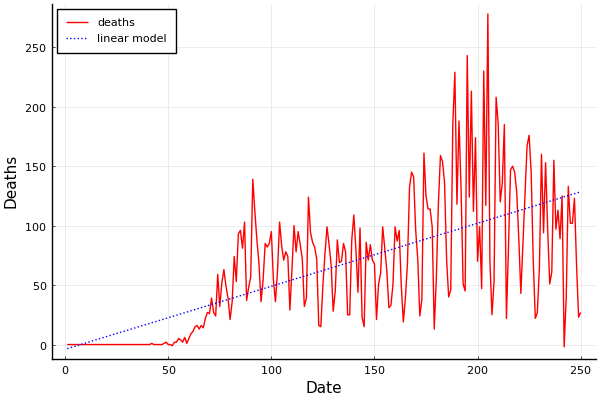

In [8]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
xlabel!("Date")
ylabel!("Deaths")

# Autoregressive models

In [9]:
# how about using the previous level of deaths? (called ``lagged outcome'')
X = [df[1:end-1,:deaths] ones(n-1)]
y = df[2:end,:deaths]
w = X\y
df[!,:pred_ar1] = vcat(X*w, df[end,:pred_linear]);

# what if we only know deaths 3 days late?
# X = [df[1:end-3,:deaths] ones(n-3)]
# y = df[4:end,:deaths]
# w = X\y
# df[!,:pred_ar1] = vcat(X*w, df[end-2:end,:pred_linear]);

# also try: 7 day lag

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_ar1])) / n

16.235586072951307

In [10]:
w

2-element Array{Float64,1}:
  0.6549421121576041
 21.73483292236317

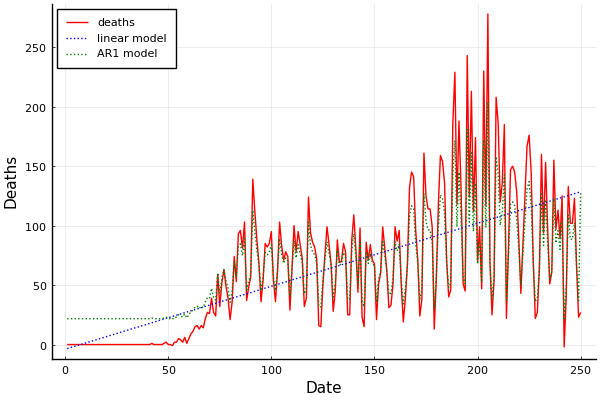

In [11]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
xlabel!("Date")
ylabel!("Deaths")

In [12]:
# how about using the date *and* lagged outcomes?
X = [df[1:end-1,:deaths] 1:(n-1) ones(n-1)]
y = df[2:end,:deaths]
w = X\y
df[!,:pred_ar1_lin] = vcat(X*w, df[end,:pred_linear]);

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_ar1_lin])) / n

19.5860246286294

About the same, so I won't plot it.

# Smoothed models

In [13]:
α = 1
X = zeros(n,n)
for i=1:n
    for j=1:n
        X[i,j] = exp(-(i-j)^2)
    end
end
y = df[:deaths]
w = X\y

df[!,:pred_smooth] = X*w

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth])) / n

7.269090004731163e-15

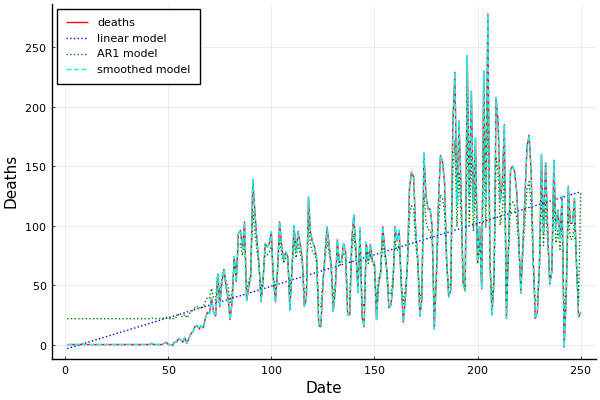

In [14]:
# cyan curve exactly matches red!
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(df.dateshort, df.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Date")
ylabel!("Deaths")

# Smoothed models, fewer features

In [15]:
# create 1 new feature for every knot_freq rows
knot_freq = 7
knots = 1:knot_freq:n
X = zeros(n,length(knots))
for i=1:n
    for j = 1:length(knots)
        X[i,j] = exp(-(i-knots[j])^2)
    end
end
# normalize rows
X = X ./ sum(X, dims=2)

X = [X ones(n)]
y = df[:deaths]
w = X\y

df[!,:pred_smooth] = X*w;

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth])) / n

23.96596083541042

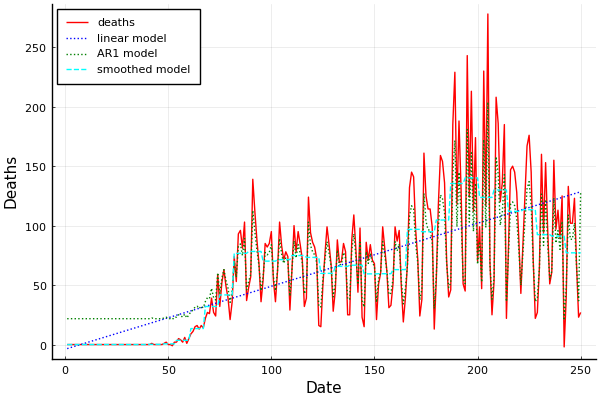

In [16]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(df.dateshort, df.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Date")
ylabel!("Deaths")

In [17]:
# AR1 + smoothing 
knot_freq = 7
knots = 1:knot_freq:n
X = zeros(n,length(knots))
for i=1:n
    for j = 1:length(knots)
        X[i,j] = exp(-(i-knots[j])^2)
    end
end
# normalize rows
X = X ./ sum(X, dims=2)

X = [df[1:end-1,:deaths] X[2:end,:] ones(n-1)]
y = df[2:end,:deaths]
w = X\y
df[!,:pred_smooth] = vcat(X*w, df[end,:pred_linear]);

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth])) / n

20.866038136298773

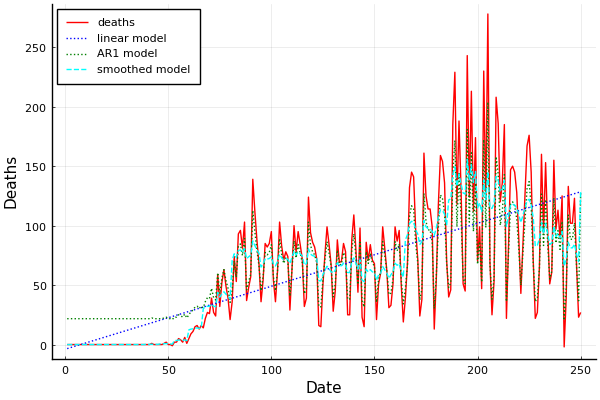

In [18]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(df.dateshort, df.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Date")
ylabel!("Deaths")

# Smooth + regularize

In [19]:
α =.3
X = zeros(n,n)
for i=1:n
    for j=1:n
        X[i,j] = exp(-(i-j)^2)
    end
end
# normalize rows
X = X ./ sum(X, dims=2)

y = df[:deaths]

# regularize 
n,d = size(X)
id = Diagonal(ones(d))
id[end,end] = 0
id[end-1,end-1] = 0
w = (X'*X + α*id)\X'*y

df[!,:pred_smooth_reg] = X*w

# evaluate error
MAE = sum(abs.(df[:deaths] - df[:pred_smooth_reg])) / n

16.45759262755545

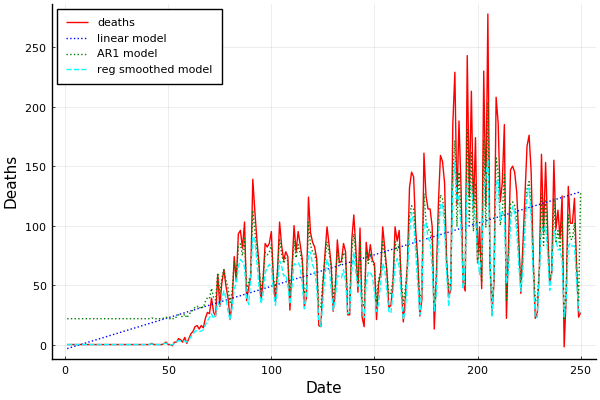

In [20]:
plot(df.dateshort, df.deaths, color=:red, label="deaths")
plot!(df.dateshort, df.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(df.dateshort, df.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(df.dateshort, df.pred_smooth_reg, color=:cyan, linestyle=:dash, label="reg smoothed model")
xlabel!("Date")
ylabel!("Deaths")